### HEO Model : 1 Battery-1 Genset. 
=========================================================================================================================
$ 
\\
$

$ 
\\
$

### Optimization parameters.


$ Q_{\mathrm{max}} \hspace{1cm}$ : Maximal energy charge stored in battery (kWh)



$ Q_{\mathrm{init}} \hspace{1.1cm}$ : Initial energy charge stored on battery (kWh)



$ Q_{\mathrm{final}} \hspace{0.9cm}$ :  Final charge stored on battery (kWh)



$ P_{\mathrm{max}\;} \hspace{1cm}$ : Maximal power available from genset (kW)



${FC}_{max} \hspace{0.7cm}$ : Maximal fuel consumption (g/h)



$ {FC}_{offset} \hspace{0.4cm}$ : Offset for fuel consumption model at P=0)



$ a \hspace{1.7cm}$ : Slope in fuel consumption model



$ b \hspace{1.7cm}$ : Intercept in fuel consumption model (=)



$ K_{\mathrm{start}} \hspace{1cm}$ : Additional fuel consumption when starting genset (kg)



$ \Delta t \hspace{1.5cm}$ : Time step in discretization (h)




$ t_{\mathrm{max}\;} \hspace{1.1cm}$ : Max time in simulation (h)



$ n \hspace{1.7cm}$ :  Number of time steps in simulation



$ t_{\mathrm{max}\;} \hspace{1.1cm}$ : Max time in simulation (h)



$ t \hspace{1.8cm}$ :  Time vector in simulation (dim(t)=n)



$ \eta^{\mathrm{toBat}} \; \hspace{0.9cm}$ :  Efficiency when charging battery



$ \eta^{\mathrm{fromBat}} \; \hspace{0.5cm}$ :   Efficiency when battery is used for load



$ L \hspace{1.6cm}$ : Vector of pre-defined load profile (must be of same length as time vector, dim(L)=dim(t)=n) (kW)

$\newline$ 


### Optimization model.

$\mathrm{minimize}\;\;\;\;\;\sum_{k=1}^n {FC}_{k\;} \cdot \frac{\Delta t}{1000}+K_{\mathrm{start}} \sum_{k=2}^n z_k$  

$\newline$ 

Fuel consumption model 1 (linear):     $\hspace{1cm} {FC}_{k\;} ={aP}_{k\;} +b-{FC}_{offset} \cdot \left(1-y_k \right)\hspace{3cm}$      $k=1,\dots ,n$

Load requirements:     $\hspace{3.5cm}L_k =P_k^{\mathrm{load}} +\eta {\;}^{\mathrm{fromBat}} {\cdot \;P}_k^{\mathrm{fromBat}}\hspace{4.2cm}$      $k=1,\dots ,n$  


Power split:   $\hspace{4.8cm}P_{k\;} =P_k^{\mathrm{load}} {+\;P}_k^{\mathrm{toBat}}\hspace{6.3cm}$   $k=1,\dots ,n$

Charge balance (initial):   $\hspace{2.8cm}Q_0 =Q_{\mathrm{init}}\hspace{6.3cm}$  

Charge balance:  $\hspace{4cm}Q_k =Q_{k-1} +\eta^{\mathrm{toBat}} \cdot \;P_k^{\mathrm{toBat}} \Delta t-\;P_k^{\mathrm{fromBat}} \Delta t\hspace{1.8cm}$     $k=1,\dots ,n$ 


Charge balance (final):     $\hspace{3cm}Q_n =Q_{\mathrm{final}}\hspace{3cm}$   


Logical conditions on genset: $\hspace{2cm}P_{k\;} \le {0\ldotp 9P}_{\mathrm{max}\;} {\cdot y}_k\hspace{6.7cm}$    $k=1,\dots ,n$ 


(0 or in 0.2P_max - 0.9Pmax):  $\hspace{1.8cm}P_{k\;} \le {0\ldotp 2P}_{\mathrm{max}\;} {\cdot y}_k\hspace{6.8cm}$    $k=1,\dots ,n$




Logical conditions on battery:   $\hspace{1.9cm}y_k^{\mathrm{toBat}} +y_{k\;}^{\mathrm{fromBat}} \le 1\hspace{6.4cm}$     $k=1,\dots ,n$  $ \\$     
$\hspace{6.9cm}P_k^{\mathrm{toBat}} \le 0\ldotp 9P_{\mathrm{max}} {\cdot y}_k^{\mathrm{toBat}}\hspace{5.7cm}$ $k=1,\dots ,n$ 


$\hspace{6.9cm}P_k^{\mathrm{fromBat}} \le 0\ldotp 9P_{\mathrm{max}} {\cdot \;y}_k^{\mathrm{fromBat}}\hspace{4.8cm}$  $k=1,\dots ,n$ 

$\newline$ 


Constraints for linearization of objective:  $\hspace{0.5cm}z_k \ge y_k -y_{k-1}\hspace{7.0cm}$ $k=2,\ldotp \ldotp \ldotp ,n$

$\newline$ 

Variable bounds:  $\hspace{4.1cm}0\ldotp 2Q_{\mathrm{max}} \le Q_k \le Q_{\mathrm{max}}\hspace{5.8cm}$ $k=0,\ldotp \ldotp \ldotp ,n$  $ \\$  
$\hspace{7cm}0\le P_k \le 0\ldotp 9P_{\mathrm{max}}\hspace{6.5cm}$  $k=1,\ldotp \ldotp \ldotp ,n$    
 
$\hspace{7cm}0\le P_k^{\mathrm{toBat}} ,P_k^{\mathrm{fromBat}} \le {0\ldotp 9P}_{\mathrm{max}}\hspace{4.3cm}$ $k=1,\ldotp \ldotp \ldotp ,n$ 


$\hspace{7cm}0\le z_k \le 1\hspace{7.8cm}$  $k=2,\ldotp \ldotp \ldotp ,n$


$ \\$ Variable types:     $\hspace{1cm}Q_{k\}\,P_k^{\mathrm{toBat}}} ,P_k^{\mathrm{fromBat}} ,z_k$ :Continuous $\hspace{1cm}P_{k\}}$  :Semi-continuous  $\hspace{1.5cm}y_k ,y_k^{\mathrm{toBat}} ,y_k^{\mathrm{fromBat}}$ :Binary

$\newline$ 

 $ \\$ $P_k \hspace{2.1cm} $:  Power from genset during time step k
 
 $ \\$ $P_k^{\mathrm{toBat}}\hspace{1.5cm}$: Power to charge battery during time step k
 
 $ \\$ $P_k^{\mathrm{fromBat}}\hspace{1.2cm}$: Power delivered from battery during time step k
 
 $ \\$ $Q_k\hspace{2.1cm}$: Energy charge on battery at the end of time step k
 
 $ \\$ $y_k\hspace{2.1cm}$: Variable equal to 1 if genset is used in time step k, variable equal to 0 if genset not used in time step k

$ \\$ $y_k^{\mathrm{toBat}}\hspace{1.6cm}$: Variable equal to 1 if battery is charged under time step k

$ \\$ $y_k^{\mathrm{fromBat}}\hspace{1.1cm}$: Variable equal to 1 if battery if used for load in time step k

$ \\$ $z_k\hspace{1.9cm}$: Variable used to linearize additional cost when starting genset (  )



$\newline $
$\newline $




$\newline $
### Importing modules.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
from gurobipy import *
from src.functions.fuel_consumption import fuelCon
from src.functions.load_window import lwd 

### Python environment.

In [2]:
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)


$\newline $
### Introducing problem Parameters.

In [3]:
Q_max = 250                                                   # maximal capacity stored on battery.
Q_0 = 0.5*Q_max                                               # inital capacity stored on battery.
Q_final = 0.5*Q_max                                           # Final capacity stored on the battery. 
eff_to_bat = 0.98                                             # battery charging efficiency.
eff_from_bat = 0.98                                           # battery transfer efficiency. 
P_A_max = 1000                                                # max output from gen set A.
dt = 1                                                        # simulation time step dt.
t_max = 60                                                    # time span for simulation = t_max hours.
t = np.atleast_2d(np.arange(0,t_max,dt)).T.conj()             # time scale in hours.
n = len(t)                                                    # number of time steps.
m = 1                                                         # number of Gensets used on the trip.
fc_j_offset = 12060                                           # genset j fuel consumption when no power gnerated (p=0) in g/h.
K_j_start = 0.0                                               # Addicitional starting cost.
V_steps = [x for x in range (0,n)]                            # Time steps vector. 
V_steps_z = V_steps[:-1]                                      # Time steps vector without the final step. 


L = lwd (200,100,10,                                          # Power requirement window.
                100,300,10,
                300,150,10,
                150,250,30,
                0,10,20,30
                )                                             # Pre-defined load porfile requirements framed in 60 time steps

$\newline $
### Creating the problem variable. 

In [4]:
Optim = LpProblem('Energy_Opt',LpMinimize)

$\newline $
### Slope, intercept and maximum fuel bound calculation.

In [5]:
a_j = (fuelCon(0.9*P_A_max, P_A_max) - fuelCon(0.2*P_A_max, P_A_max)) /(0.7*P_A_max) #slope.
b_j = fuelCon(0.2*P_A_max, P_A_max) - a_j*0.2*P_A_max #Intercept.
maxFC = fuelCon(0.9*P_A_max,P_A_max) # Max fuel bound.
print('FC Linear model caracteristics')
print('-----------------------------')
print('Slope =', a_j)
print('Intercept =', b_j)

FC Linear model caracteristics
-----------------------------
Slope = 186.3
Intercept = 12059.999999999993


$\newline $
### Setting-up decision Variables.

In [6]:
Q_bat = LpVariable.dicts("Q_bat", V_steps, lowBound=0.2*Q_max, upBound=Q_max, cat = LpContinuous)  # Battery charge at time step k.
P_From_bat = LpVariable.dicts("P_From_bat", V_steps, lowBound=0, upBound=0.9*P_A_max, cat = LpContinuous) # Power transfered from the battery to the load.
P_A = LpVariable.dicts("P_A", V_steps, lowBound=0, upBound=0.9*P_A_max, cat = LpContinuous)  # Power generated by the Genset A.
P_A_load = LpVariable.dicts("P_A_load", V_steps, lowBound=0, upBound=0.9*P_A_max, cat= LpContinuous) # Power transfered from the Genset A to the load at time step k.
Z =  LpVariable.dicts("Z", V_steps_z, lowBound=0, upBound=1, cat = LpInteger) # Aditional cost fuel oil consumption when starting Genset j.
FC_A = LpVariable.dicts("FC_A", V_steps, lowBound=0, upBound= maxFC, cat = LpContinuous) # Specific fuel oil consumption.
P_A_to_bat =  LpVariable.dicts("P_A_to_bat", V_steps, lowBound=0, upBound=0.9*P_A_max, cat = LpContinuous) 
Y_to_bat = LpVariable.dicts("Y_to_bat", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Genset selecter to charge the battery at time step k. 
Y_from_bat = LpVariable.dicts("Y_from_bat", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Battery selecter to transfert to the Genset j st time step k.
Y = LpVariable.dicts("Y", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Genset selecter : work ==> Y=1, Not work ==> Y=0.

$\newline $
### Setting-up the objective function.

In [7]:
FC = sum(FC_A[k] for k in V_steps) * dt/1000  # sum of the fuel oil comsumption for all gensets over all k steps.
L_added_cost = sum(Z[i] for i in V_steps_z) * K_j_start  # Sum of all of the additional costs including starting costs. 
Optim += lpSum (FC + L_added_cost), "objective function minimization fuel oil consumption" 
print(FC)

0.001*FC_A_0 + 0.001*FC_A_1 + 0.001*FC_A_10 + 0.001*FC_A_11 + 0.001*FC_A_12 + 0.001*FC_A_13 + 0.001*FC_A_14 + 0.001*FC_A_15 + 0.001*FC_A_16 + 0.001*FC_A_17 + 0.001*FC_A_18 + 0.001*FC_A_19 + 0.001*FC_A_2 + 0.001*FC_A_20 + 0.001*FC_A_21 + 0.001*FC_A_22 + 0.001*FC_A_23 + 0.001*FC_A_24 + 0.001*FC_A_25 + 0.001*FC_A_26 + 0.001*FC_A_27 + 0.001*FC_A_28 + 0.001*FC_A_29 + 0.001*FC_A_3 + 0.001*FC_A_30 + 0.001*FC_A_31 + 0.001*FC_A_32 + 0.001*FC_A_33 + 0.001*FC_A_34 + 0.001*FC_A_35 + 0.001*FC_A_36 + 0.001*FC_A_37 + 0.001*FC_A_38 + 0.001*FC_A_39 + 0.001*FC_A_4 + 0.001*FC_A_40 + 0.001*FC_A_41 + 0.001*FC_A_42 + 0.001*FC_A_43 + 0.001*FC_A_44 + 0.001*FC_A_45 + 0.001*FC_A_46 + 0.001*FC_A_47 + 0.001*FC_A_48 + 0.001*FC_A_49 + 0.001*FC_A_5 + 0.001*FC_A_50 + 0.001*FC_A_51 + 0.001*FC_A_52 + 0.001*FC_A_53 + 0.001*FC_A_54 + 0.001*FC_A_55 + 0.001*FC_A_56 + 0.001*FC_A_57 + 0.001*FC_A_58 + 0.001*FC_A_59 + 0.001*FC_A_6 + 0.001*FC_A_7 + 0.001*FC_A_8 + 0.001*FC_A_9


$\newline $
$\newline $
### Setting-up problem constraints.

In [8]:

for k in V_steps:

  # Fuel oil consumption constraint.
  Optim += FC_A[k] == P_A[k]*a_j + b_j - fc_j_offset*(1-Y[k])     

  # Load requirements constraints
  Optim += P_A_load[k] + eff_from_bat*P_From_bat[k] == L[k]       
  Optim += P_A_load[k] + P_A_to_bat[k] == P_A[k]                  


  # Genset logical constraints.
  Optim += P_A[k]  <= 0.9 * P_A_max * Y[k]
  Optim += P_A[k]  >= 0.2 * P_A_max * Y[k]
  Optim += Y[k]  >= 0
  Optim += Y[k]  <= 1
    
  # Battery charging logical constraints.
  Optim += P_A_to_bat[k] <= 0.9 * P_A_max * Y_to_bat[k]
  Optim += P_From_bat[k] <= 0.9 * P_A_max * Y_from_bat[k]
  Optim += Y_to_bat[k] + Y_from_bat[k]  <= 1
  

  # Charge balance logical constraints.
  if k == V_steps[0] :                                            
    Optim += Q_bat[k] == Q_0 + eff_to_bat*P_A_to_bat[k]*dt - P_From_bat[k]*dt


  else :  
    Optim += Q_bat[k] == Q_bat[k-1] + eff_to_bat*P_A_to_bat[k]*dt - P_From_bat[k]*dt

    
# Additional starting costs constraint.
for k in range(V_steps[0], V_steps[-1]): 
  Optim += Z[k] >= Y[k + 1] - Y[k] 
  
# Charge balance at the Final time step.
Optim += Q_bat[V_steps[-1]] == Q_final

$\newline $
$\newline $
### Solving the problem.

In [9]:
status = Optim.solve(GUROBI())

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i3-4000M CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 720 rows, 599 columns and 1617 nonzeros
Model fingerprint: 0xc21a6466
Variable types: 360 continuous, 239 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e-03, 1e-03]
  Bounds range     [1e+00, 2e+05]
  RHS range        [7e-12, 3e+02]
Presolve removed 577 rows and 430 columns
Presolve time: 0.01s
Presolved: 143 rows, 169 columns, 402 nonzeros
Variable types: 111 continuous, 58 integer (58 binary)
Found heuristic solution: objective 2739.3562804

Root relaxation: objective 2.712472e+03, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

$\newline $
$\newline $
### Printing optimization status.

In [10]:
LpStatus[status]

'Optimal'

$\newline $
$\newline $
### Printing constraints per each time step.

In [11]:
print(Optim.variables)

<bound method LpProblem.variables of Energy_Opt:
MINIMIZE
0.001*FC_A_0 + 0.001*FC_A_1 + 0.001*FC_A_10 + 0.001*FC_A_11 + 0.001*FC_A_12 + 0.001*FC_A_13 + 0.001*FC_A_14 + 0.001*FC_A_15 + 0.001*FC_A_16 + 0.001*FC_A_17 + 0.001*FC_A_18 + 0.001*FC_A_19 + 0.001*FC_A_2 + 0.001*FC_A_20 + 0.001*FC_A_21 + 0.001*FC_A_22 + 0.001*FC_A_23 + 0.001*FC_A_24 + 0.001*FC_A_25 + 0.001*FC_A_26 + 0.001*FC_A_27 + 0.001*FC_A_28 + 0.001*FC_A_29 + 0.001*FC_A_3 + 0.001*FC_A_30 + 0.001*FC_A_31 + 0.001*FC_A_32 + 0.001*FC_A_33 + 0.001*FC_A_34 + 0.001*FC_A_35 + 0.001*FC_A_36 + 0.001*FC_A_37 + 0.001*FC_A_38 + 0.001*FC_A_39 + 0.001*FC_A_4 + 0.001*FC_A_40 + 0.001*FC_A_41 + 0.001*FC_A_42 + 0.001*FC_A_43 + 0.001*FC_A_44 + 0.001*FC_A_45 + 0.001*FC_A_46 + 0.001*FC_A_47 + 0.001*FC_A_48 + 0.001*FC_A_49 + 0.001*FC_A_5 + 0.001*FC_A_50 + 0.001*FC_A_51 + 0.001*FC_A_52 + 0.001*FC_A_53 + 0.001*FC_A_54 + 0.001*FC_A_55 + 0.001*FC_A_56 + 0.001*FC_A_57 + 0.001*FC_A_58 + 0.001*FC_A_59 + 0.001*FC_A_6 + 0.001*FC_A_7 + 0.001*FC_A_8 + 0.001*F

In [12]:
for v in Optim.variables():
    print(v.name, "=", v.varValue )

FC_A_0 = 49319.99994501809
FC_A_1 = 67477.9779808461
FC_A_10 = 0.0
FC_A_11 = 62849.575177009596
FC_A_12 = 0.0
FC_A_13 = 79750.98292378176
FC_A_14 = 0.0
FC_A_15 = 51389.99999999999
FC_A_16 = 55529.99999999999
FC_A_17 = 59669.99999999999
FC_A_18 = 63809.99999999999
FC_A_19 = 67950.0
FC_A_2 = 3.313971319585108e-12
FC_A_20 = 67950.0
FC_A_21 = 64844.99999999999
FC_A_22 = 61740.0
FC_A_23 = 58634.99999999999
FC_A_24 = 91093.3069554352
FC_A_25 = 52424.99999999999
FC_A_26 = 49320.00000000003
FC_A_27 = 0.0
FC_A_28 = 72207.25114535612
FC_A_29 = 0.0
FC_A_3 = 73284.92711370264
FC_A_30 = 69771.1534705367
FC_A_31 = 0.0
FC_A_32 = 72393.7857071048
FC_A_33 = 0.0
FC_A_34 = 75016.41794367289
FC_A_35 = 0.0
FC_A_36 = 77639.050180241
FC_A_37 = 0.0
FC_A_38 = 80261.68241680908
FC_A_39 = 0.0
FC_A_4 = 0.0
FC_A_40 = 82884.3146533772
FC_A_41 = 0.0
FC_A_42 = 85506.94688994528
FC_A_43 = 0.0
FC_A_44 = 63256.44616467276
FC_A_45 = 49641.20689655172
FC_A_46 = 50283.62068965517
FC_A_47 = 50926.034482758616
FC_A_48 = 5156

$\newline $
$\newline $
### Calculating the optimized fuel comsumption.

In [13]:
print("Total saved fuel comsumption of the trip:", value(Optim.objective),'kg') 

Total saved fuel comsumption of the trip: 2739.3562804291314 kg


$\newline $
### Pre-processing visualisation data.

In [14]:
# Constructing list out of the P_A vector.

P_A_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_A_'+ str(i)):
      P_A_list.append(v.varValue)
print(P_A_list)

# Constructing list out of the P_A_load vector.

P_A_load_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_A_load_'+ str(i)):
      P_A_load_list.append(v.varValue)
print(P_A_load_list)

# Constructing list out of the P_A_to_bat vector.

P_A_to_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_A_to_bat_'+ str(i)):
      P_A_to_bat_list.append(v.varValue)
print(P_A_to_bat_list)

# Constructing list out of the P_From_bat.

P_From_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_From_bat_'+ str(i)):
      P_From_bat_list.append(v.varValue)
print(P_From_bat_list)

# Constructing list out of the Q_bat vector.

Q_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('Q_bat_'+ str(i)):
      Q_bat_list.append(v.varValue)
print(Q_bat_list)

# constructing list out of the FC_A vector.

FC_A_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('FC_A_'+ str(i)):
      FC_A_list.append(v.varValue/1000)
print(FC_A_list)

# Constructing list out of load profil vector.

d_load_list = []              
for i in V_steps:
    d_load_list.append(L[i])
print(d_load_list)



[199.99999970487437, 297.46633376728994, 2.842170943040401e-14, 272.6225183951133, 0.0, 363.343977046601, 0.0, 211.11111111111111, 233.33333333333331, 255.55555555555554, 277.77777777777777, 300.0, 5.684341886080802e-14, 300.0, 283.3333333333333, 266.6666666666667, 250.0, 424.22601693738693, 216.66666666666666, 200.0000000000002, 0.0, 322.8515896154381, 0.0, 328.6362163913185, 309.7753809475937, 0.0, 323.8528486693763, 0.0, 337.9303163911589, 0.0, 352.0077841129415, 0.0, 366.0852518347241, 0.0, 0.0, 380.16271955650666, 0.0, 394.2401872782893, 0.0, 274.8064743138635, 201.72413793103448, 205.17241379310343, 208.6206896551724, 212.06896551724137, 215.51724137931035, 283.27548706557457, 218.9655172413793, 222.41379310344826, 225.86206896551724, 229.31034482758622, 232.75862068965517, 236.20689655172413, 239.65517241379308, 243.10344827586206, 246.55172413793105, 250.0, 2.842170943040401e-14, 237.91475773983066, 0.0, 204.12328196584753]
[200.0, 188.88888888888889, 0.0, 122.22222222222223, 0

$\newline $

### Load requirement window. 

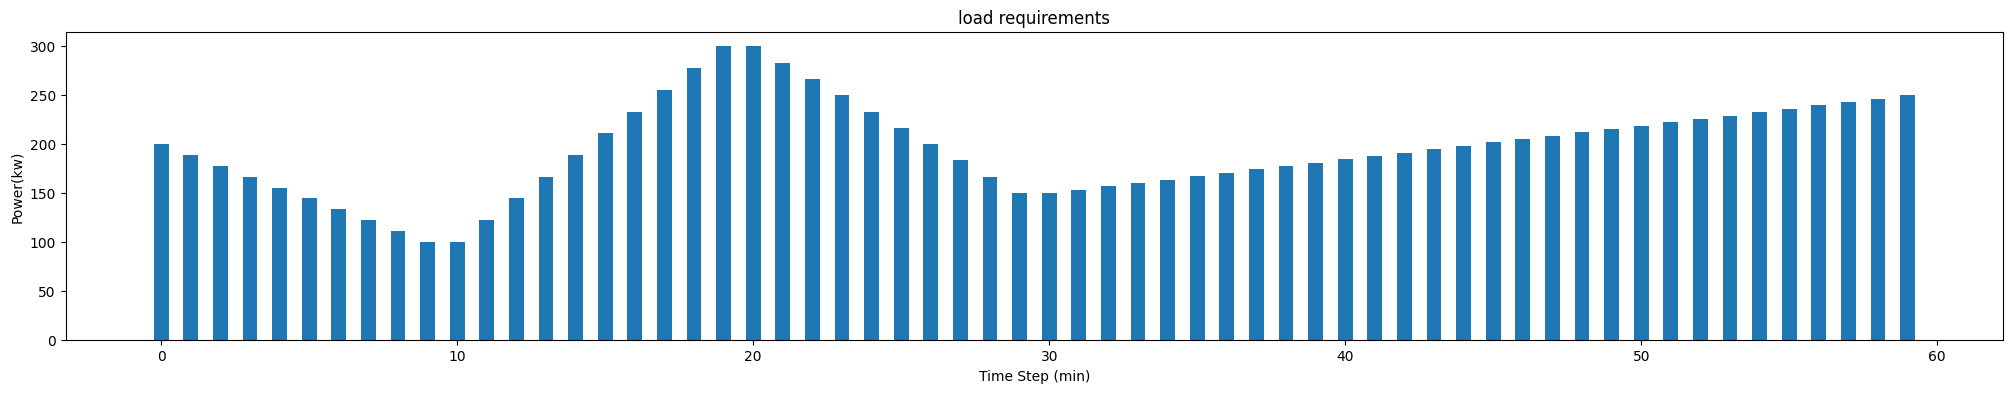

In [15]:
plt.rcParams["figure.figsize"] =  (25,4)
plt.bar(V_steps,d_load_list, width=0.5)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.title('load requirements')
plt.show()

In [16]:
print(V_steps,L)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] {0: 200.0, 1: 188.88888888888889, 2: 177.77777777777777, 3: 166.66666666666669, 4: 155.55555555555554, 5: 144.44444444444446, 6: 133.33333333333334, 7: 122.22222222222223, 8: 111.11111111111111, 9: 100.0, 10: 100.0, 11: 122.22222222222223, 12: 144.44444444444446, 13: 166.66666666666666, 14: 188.88888888888889, 15: 211.11111111111111, 16: 233.33333333333331, 17: 255.55555555555554, 18: 277.77777777777777, 19: 300.0, 20: 300.0, 21: 283.3333333333333, 22: 266.6666666666667, 23: 250.0, 24: 233.33333333333331, 25: 216.66666666666666, 26: 200.0, 27: 183.33333333333331, 28: 166.66666666666666, 29: 150.0, 30: 150.0, 31: 153.44827586206895, 32: 156.89655172413794, 33: 160.3448275862069, 34: 163.79310344827587, 35: 167.24137931034483, 36: 170.68965517241378, 37: 174.13

$\newline $
### Generated genset power.

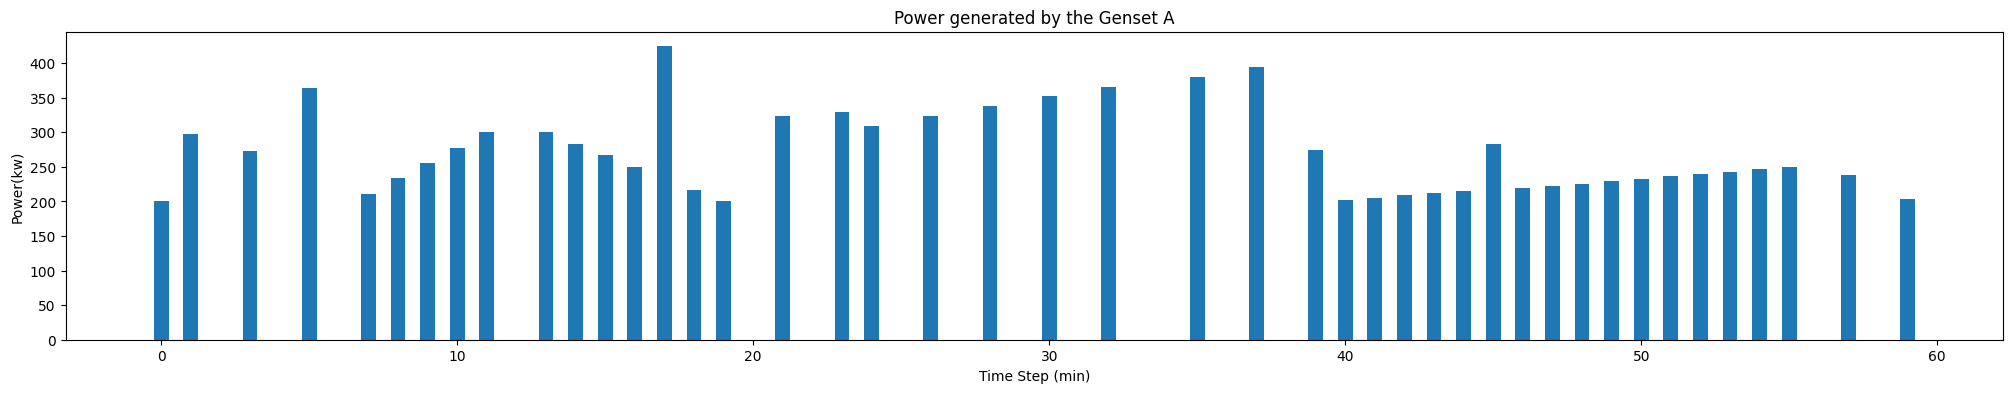

In [17]:
plt.rcParams["figure.figsize"] =  (25,4)
plt.bar(V_steps,P_A_list, width=0.5)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.title('Power generated by the Genset A')
plt.show()

In [18]:
print(V_steps,P_A_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] [199.99999970487437, 297.46633376728994, 2.842170943040401e-14, 272.6225183951133, 0.0, 363.343977046601, 0.0, 211.11111111111111, 233.33333333333331, 255.55555555555554, 277.77777777777777, 300.0, 5.684341886080802e-14, 300.0, 283.3333333333333, 266.6666666666667, 250.0, 424.22601693738693, 216.66666666666666, 200.0000000000002, 0.0, 322.8515896154381, 0.0, 328.6362163913185, 309.7753809475937, 0.0, 323.8528486693763, 0.0, 337.9303163911589, 0.0, 352.0077841129415, 0.0, 366.0852518347241, 0.0, 0.0, 380.16271955650666, 0.0, 394.2401872782893, 0.0, 274.8064743138635, 201.72413793103448, 205.17241379310343, 208.6206896551724, 212.06896551724137, 215.51724137931035, 283.27548706557457, 218.9655172413793, 222.41379310344826, 225.86206896551724, 229.31034482758622

$\newline $
### Realised power from the genset to load.

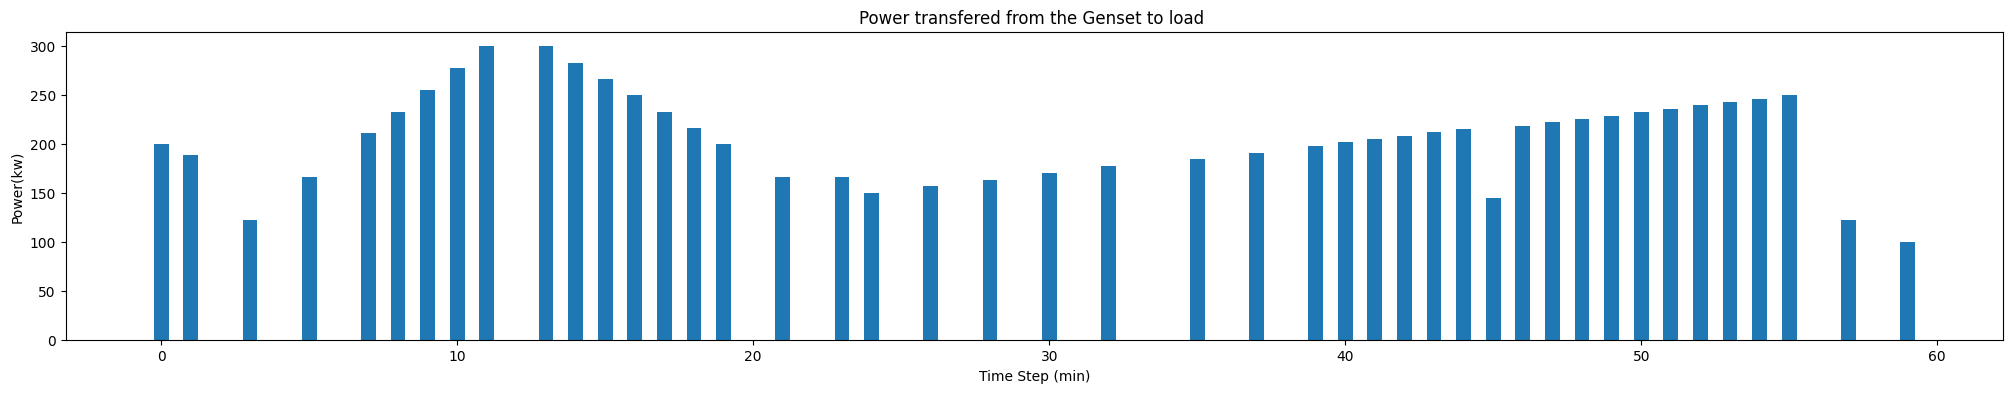

In [19]:
plt.rcParams["figure.figsize"] = (25,4)
plt.bar(V_steps,P_A_load_list, width=0.5)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.title('Power transfered from the Genset to load ')
plt.show()

In [20]:
print(V_steps,P_A_load_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] [200.0, 188.88888888888889, 0.0, 122.22222222222223, 0.0, 166.66666666666666, 0.0, 211.11111111111111, 233.33333333333331, 255.55555555555554, 277.77777777777777, 300.0, 0.0, 300.0, 283.3333333333333, 266.6666666666667, 250.0, 233.33333333333331, 216.66666666666666, 200.0, 0.0, 166.66666666666666, 0.0, 166.66666666666669, 150.0, 0.0, 156.89655172413794, 0.0, 163.79310344827587, 0.0, 170.68965517241378, 0.0, 177.58620689655172, 0.0, 0.0, 184.48275862068965, 0.0, 191.3793103448276, 0.0, 198.27586206896552, 201.72413793103448, 205.17241379310343, 208.6206896551724, 212.06896551724137, 215.51724137931035, 144.44444444444446, 218.9655172413793, 222.41379310344826, 225.86206896551724, 229.31034482758622, 232.75862068965517, 236.20689655172413, 239.65517241379308, 2

$\newline $
### Realised power to charge the battery.

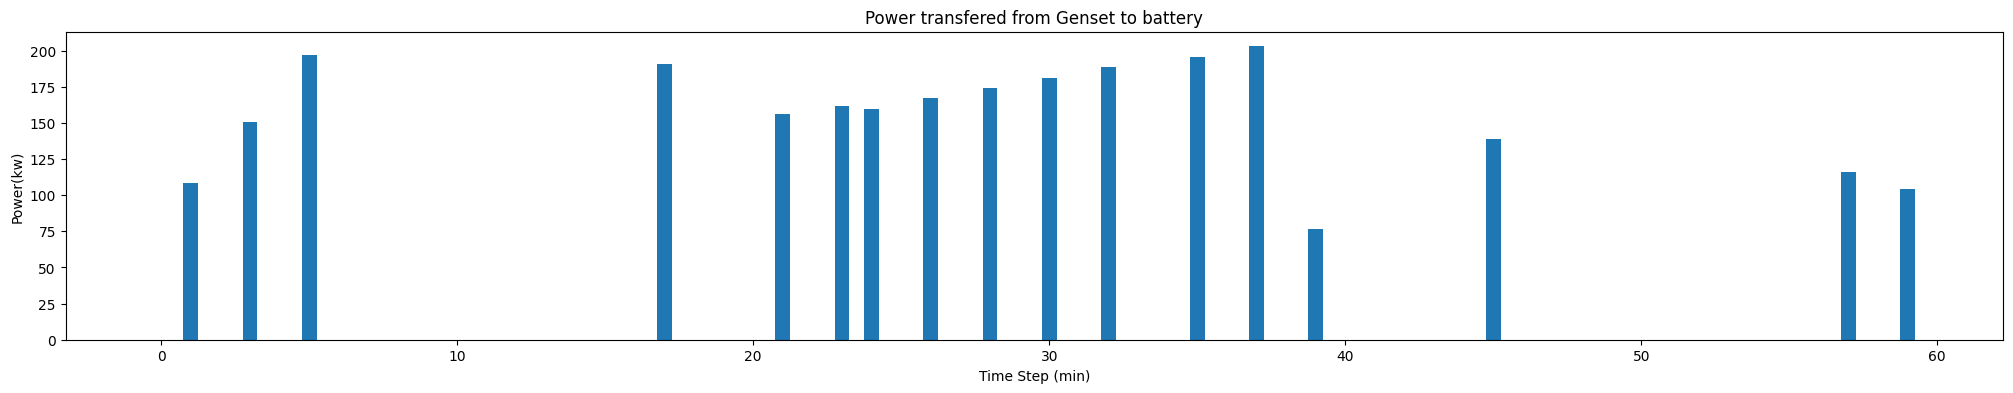

In [21]:
plt.rcParams["figure.figsize"] =  (25,4)                
plt.bar(V_steps,P_A_to_bat_list, width=0.5)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.xticks()
plt.title('Power transfered from Genset to battery')
plt.show()

In [22]:
print(V_steps,P_A_to_bat_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] [-2.917922972671901e-07, 108.57744487840102, 2.1316282072803006e-14, 150.40029617289102, 0.0, 196.67731037993434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.684341886080802e-14, 0.0, 0.0, 0.0, 0.0, 190.89268360405364, 0.0, 1.9895196601282805e-13, 0.0, 156.18492294877143, 0.0, 161.96954972465178, 159.7753809475937, 0.0, 166.9562969452384, 0.0, 174.13721294288302, 0.0, 181.31812894052774, 0.0, 188.49904493817237, 0.0, 0.0, 195.67996093581698, 0.0, 202.8608769334617, 0.0, 76.53061224489795, 0.0, 0.0, 0.0, 0.0, 0.0, 138.83104262113008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.842170943040401e-14, 115.69253551760843, 0.0, 104.12328196584754]


$\newline $
### Realised power from the battery to load.

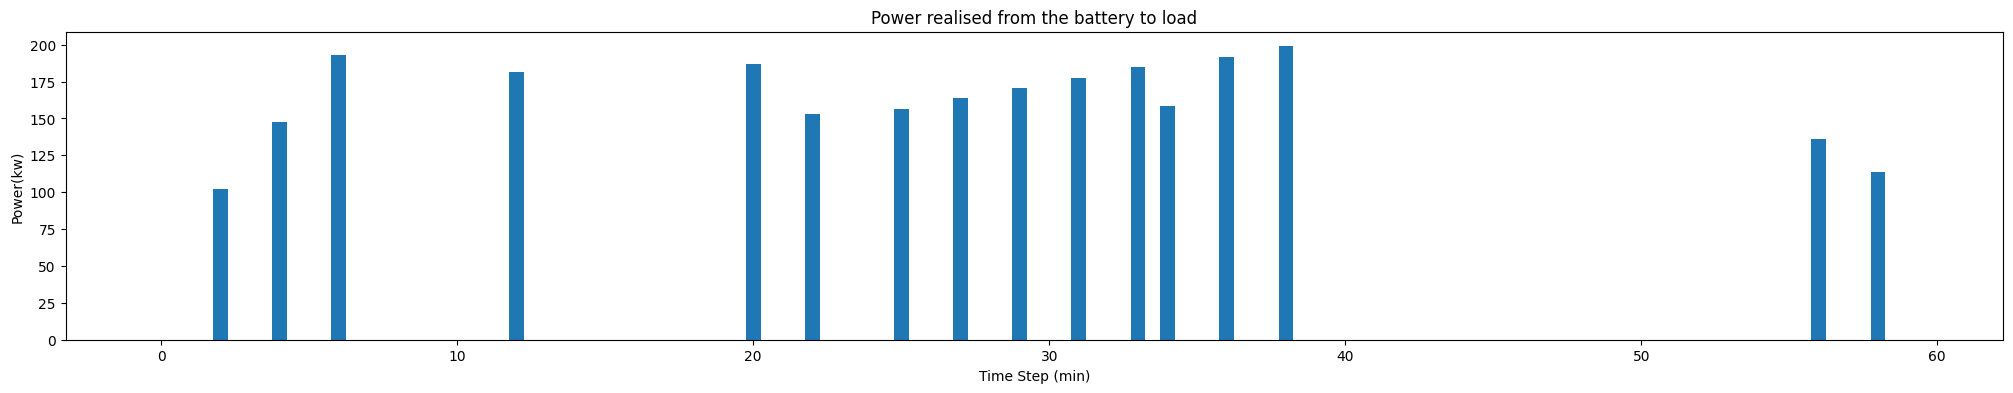

In [23]:
plt.rcParams["figure.figsize"] =  (25,4)
plt.bar(V_steps,P_From_bat_list, width=0.5)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.title('Power realised from the battery to load')
plt.show()

In [24]:
print(V_steps,P_From_bat_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] [0.0, 0.0, 102.04081632653062, 0.0, 147.39229024943313, 0.0, 192.7437641723356, 0.0, 0.0, 0.0, 0.0, 0.0, 181.40589569160997, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 187.07482993197277, 0.0, 153.06122448979593, 0.0, 0.0, 156.57987332864178, 0.0, 163.61717100633356, 0.0, 170.65446868402535, 0.0, 177.6917663617171, 0.0, 184.72906403940888, 158.7301587301587, 0.0, 191.7663617171006, 0.0, 198.8036593947924, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.0544217687075, 0.0, 113.37868480725623, 0.0]


### Battery charge balance.

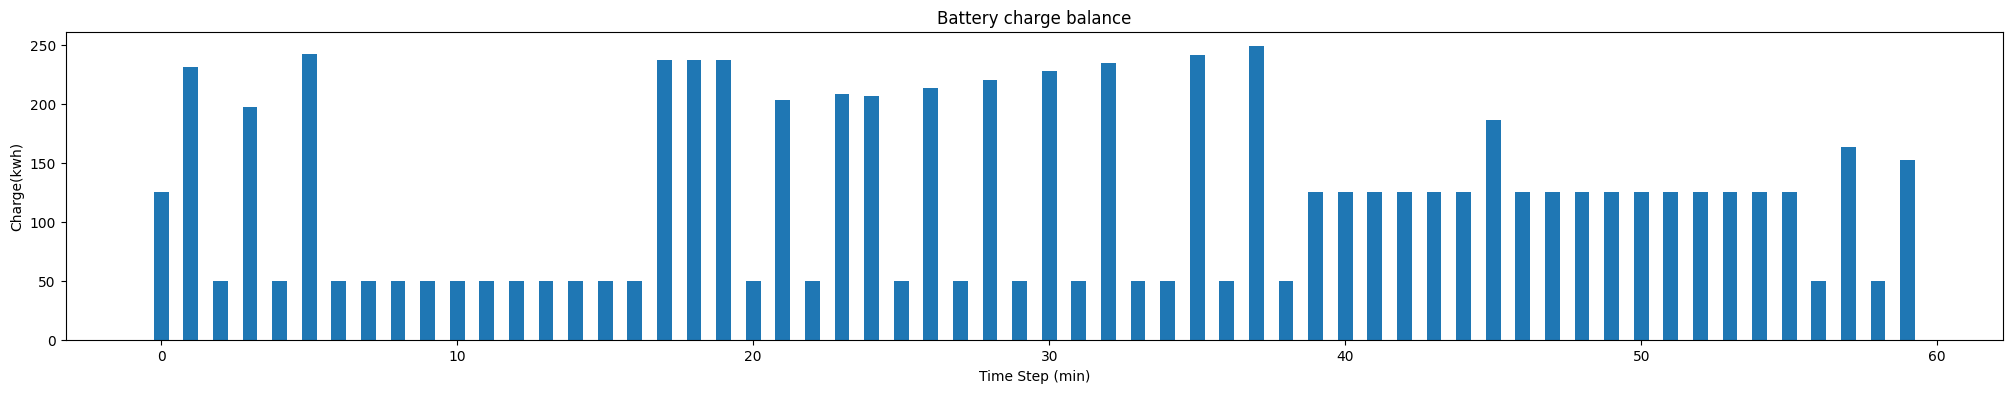

In [25]:
plt.rcParams["figure.figsize"] = (25,4)
plt.bar(V_steps,Q_bat_list, width=0.5)
plt.xlabel('Time Step (min)')
plt.ylabel('Charge(kwh)')
plt.title('Battery charge balance')
plt.show()

In [26]:
print(V_steps,Q_bat_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] [124.99999971077689, 231.40589569160989, 50.0, 197.3922902494332, 50.0, 242.7437641723356, 50.00000000000002, 50.00000000000002, 50.00000000000002, 50.00000000000002, 50.00000000000002, 50.00000000000002, 50.0, 50.00000000000002, 50.00000000000002, 50.00000000000002, 50.00000000000002, 237.0748299319726, 237.0748299319726, 237.07482993197277, 50.0, 203.06122448979596, 50.0, 208.73015873015873, 206.57987332864178, 50.0, 213.61717100633362, 50.0, 220.65446868402537, 50.0, 227.69176636171716, 50.0, 234.7290640394089, 50.0, 50.0, 241.76636171710064, 50.0, 248.80365939479245, 50.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 186.05442176870747, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 50.0, 163.37868480725626, 50.0, 152.0408163265306]


$\newline $
### Genset fuel consumption.

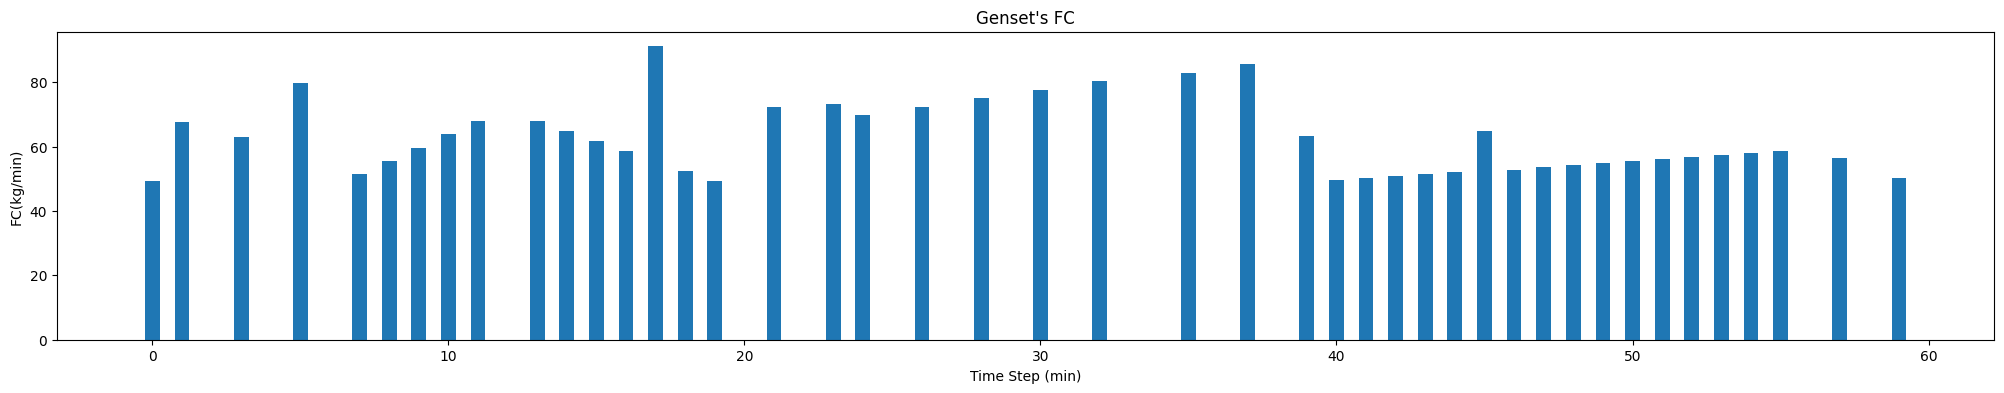

In [27]:
plt.rcParams["figure.figsize"] = (25,4)
plt.bar(V_steps,FC_A_list, width=0.5)
plt.xlabel('Time Step (min)')
plt.ylabel('FC(kg/min)')
plt.title("Genset's FC")
plt.show()

In [28]:
print(V_steps, FC_A_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] [49.31999994501809, 67.4779779808461, 0.0, 62.8495751770096, 0.0, 79.75098292378176, 0.0, 51.38999999999999, 55.529999999999994, 59.669999999999995, 63.809999999999995, 67.95, 3.313971319585108e-15, 67.95, 64.845, 61.74, 58.63499999999999, 91.0933069554352, 52.42499999999999, 49.32000000000003, 0.0, 72.20725114535611, 0.0, 73.28492711370264, 69.77115347053669, 0.0, 72.39378570710481, 0.0, 75.01641794367289, 0.0, 77.639050180241, 0.0, 80.26168241680908, 0.0, 0.0, 82.88431465337719, 0.0, 85.50694688994528, 0.0, 63.25644616467276, 49.641206896551715, 50.283620689655166, 50.92603448275862, 51.56844827586207, 52.21086206896551, 64.83422324031655, 52.853275862068955, 53.495689655172406, 54.13810344827586, 54.780517241379314, 55.42293103448275, 56.0653448275862, 56.

In [29]:
print(sum(FC_A_list)*dt)

2739.356280429132


$\newline $
$\newline $
### Trip power flow bar chart.

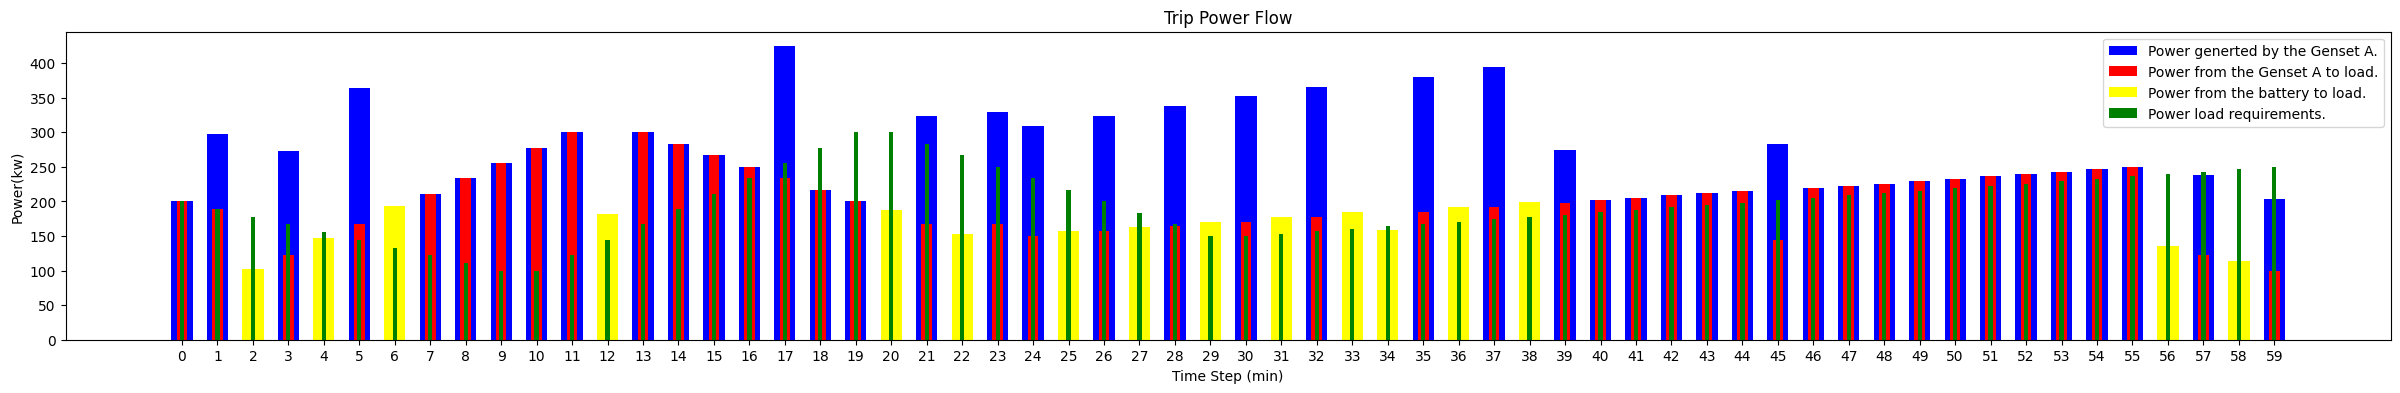

In [30]:
 
plt.rcParams["figure.figsize"] = (30,4)

gridnumber = V_steps

b1 = plt.bar(gridnumber, P_A_list, color="blue", width=0.6,
                label="Power generted by the Genset A.", align="center")

b2 = plt.bar(gridnumber, P_A_load_list, color="red", width=0.3,
                label="Power from the Genset A to load.", align="center")

b3 = plt.bar(gridnumber, P_From_bat_list, color="yellow", width=0.6,
                label="Power from the battery to load.", align="center")

b4 = plt.bar(gridnumber,d_load_list , color="green", width=0.12,
                label="Power load requirements.", align="center")

plt.title('Trip Power Flow')
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.xticks(gridnumber)
plt.legend(bbox_to_anchor= (1, 1))
plt.show()

